# NTDS assignment 2: network models
[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), *PhD student*, [EPFL](http://epfl.ch) [LTS4](http://lts4.epfl.ch)

For this assignment we will work on a network representing the collaboration between scientists in the field of General Relativity and Quantum Cosmology. The network comes from [SNAP](http://snap.stanford.edu/data/ca-GrQc.html) and is described as follows:

> Arxiv GR-QC (General Relativity and Quantum Cosmology) collaboration network is from the e-print [arXiv](https://arxiv.org) and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. If an author *i* co-authored a paper with author *j*, the graph contains a undirected edge from *i* to *j*. If the paper is co-authored by *k* authors this generates a completely connected (sub)graph on *k* nodes. The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv.

**Note** : I have modified the G.degree() codes in the second part for working with networkx 2.0 version , because I
    had coded everything else according to that. Everything else remains the same. I hope it is not an inconvenience.'

In [1]:
%matplotlib inline

import os
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings
import math
warnings.filterwarnings('ignore')

In [2]:
G = nx.read_edgelist(os.path.join('data', 'arxiv_collaboration_network.txt')) #Reading the network

In [3]:
print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))



My network has 5242 nodes.
My network has 14496 edges.


In [13]:
N = len(G.nodes())
E = G.size()

## 1. Comparing to model networks

1.1 In this part of the assignment, you have to create an Erdős–Rényi and Barabási-Albert graph using NetworkX, and compare them to the collaboration network. Try to simulate the original network as best as you can. When choosing parameters for the networks, take into account the number of vertices and edges of the original network. The number of vertices should be exactly the same. Comment on your choice of parameters.

**Barabasi Albert Model**
I have reimplemented the model instead of using the library function : `nx.barabasi_albert_model(num_nodes,num_nodex_per_iter)` because 
- It allowed me get my understanding of the process crystal clear.
- It allows me to tune one of the three parameters from m0,m and t. I've tuned m to get a close enough value of giant component.
- It is a fun coding exercise :)

In [14]:
#To genererate a BA model with given paras
def generate_barabasi_albert(M0,t,m,verbose = False): #t is N-M0, m = math.ceil((E-M0)/t)
    M = nx.Graph()
    N = t + M0
    M.add_nodes_from(range(M0))       
    nodes = list(range(M0))
    random.shuffle(nodes)      #So that there is no pattern since otherwise loop will visit the nodes in the same order
    for i in nodes:        #initializing the M0 nodes
        if(len(M[i]) != 0):      #Pass if it already have at least one edge
            continue
        target = np.random.randint(M0)   #Choose the target randomly
        while(target == i): #Avoiding self loops
            target = np.random.randint(M0)
        M.add_edge(i,target)    #adding the edge
    for n in range(M0,N):  #Now, adding the remaining nodes
        M.add_node(n)        
        if(verbose):     #For debugging or tracking progress since BA model can take time to create
            if(n%100 == 0):
                print(n)
        sum_edges = 2*M.size()     #Total links
        dist = [len(M[i])/sum_edges for i in list(range(n))] #Calculating the probability distribution
        for j in range(m):
            M.add_edge(n,np.random.choice(list(range(n)), p = dist)) #choosing the target nodes with weighed dist. and adding edge
    return M

** 34x Speedup! On Erdos Renyi Graph self implementation compared to naive implementation**

Using Numpy's array operations and slicing instead of 1 by 1 iteration through  N choose 2 pairs, a massive speedup is obtained with the below function executing in just **28 seconds** for given N comparated to **1003 seconds ~ 17 minutes** for the naive slow one at p = 0.01 and is even sometimes a bit faster than the inbuilt function `nx.erdos_renyi(num_nodes,probability)`.

It does away with the inner loop of the slow function using numpy slicing and zip

In [15]:
def generate_erdos_renyi(N,pr):        #Fast ER model/
    er = nx.Graph()
    er.add_nodes_from(range(N))
    for i in range(N):
        nodes = np.array(list(range(i+1,N)))
        decision = np.random.choice(2,N-i-1,p = [1-pr,pr])    #Choose the next N-i-1 at once
        decision = nodes[decision == 1]         
        er.add_edges_from(zip([i]*len(decision),decision)) #Add the edges
    return er

def generate_erdos_renyi_slow(N,pr): #Naive implementation
    er = nx.Graph()
    er.add_nodes_from(range(N))     #add all the nodes with 0 eadges at start
    #start = time.time()
    for i in range(N):            
        if(i%100 == 0):             #Again this can be very slow, to track progress
            print(i)
        for j in range(i+1,N):      #for the nodes ahead in list
            decision = np.random.choice(2,p = [1-pr,pr])    #Choose 1 nde and repeat. This loop is implicit in fast.
            if(decision):
                er.add_edge(i,j)   #Adding the edge
#   print(time.time()-start)
    return(er)

In [16]:
M0 = 2000   #The free parameter 
t = N - M0                        #all other params are fixed
m = math.ceil((E - M0)/t)           #Calculating all other params
# print(M0, t, m)
ba =  generate_barabasi_albert(M0,t,m,verbose = False)     #Fetching the models
er = generate_erdos_renyi(N,2*E/(N*(N-1)))    #The p is such that Expected edges is same. Explained below.

2000 3242 4


**Parameter for Erdos Renyi**:

I match the number of vertices and the expected number of edges. So, N = 5242 is the number of nodes and 
as, <center>
$\mathbb{E}[\text{# Edges}] = {n \choose 2}\frac{p}{2}$
$p = \frac{2\mathbb{E}[\text{# Edges}]}{n \choose 2}$

So, putting $p = \frac{14496*2}{5242*5241}$

**Parameter for Barabasi Albert Model**
The parameter t and m are determined from m as follows:
<center>
$
t = N - M0 \\
m = \lceil\frac{N-M0}{t}\rceil
$
</center>
with M0 as free parameter which is tuned to get a close enough Giant component size.

In [17]:
print('My Erdős–Rényi network has {} nodes.'.format(len(er.nodes())))
print('My Erdős–Rényi network has {} edges.'.format(er.size()))
print('My Barabási-Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabási-Albert network has {} edges.'.format(ba.size()))

My Erdős–Rényi network has 5242 nodes.
My Erdős–Rényi network has 14409 edges.
My Barabási-Albert network has 5242 nodes.
My Barabási-Albert network has 14350 edges.


1.2 Check the size of the largest connected component in each graph and compare them to the original network. In the Erdős–Rényi model, what should the probability of creating each edge be in order to have the same expected size of the largest component? Justify. Generate a graph with this parameter to check if you indeed get a similar value.

In [19]:
#Comparing the size of the Giant Components of the three graphs. One of the properties. 

giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_G.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

4158
5219
5176


**Calculation of parameters for Erdos - Renyi Graph**
$$
\mathbb{S} = \frac{N_{giant}}{N} \\
\mathbb{S} = 1 - e^{-<k>\mathbb{S}} \\
<k> \ = \ -\frac{\log(1-\mathbb{S})}{\mathbb{S}}
$$

As <k> = $\frac{N-1}{2}$, So,
<center>
$\Rightarrow p = -\frac{\log(1-\mathbb{S})}{\mathbb{S}}*\frac{1}{N-1}$

In [20]:
s = len(giant_G.nodes())/N
p_giant = (-math.log(1-s)/s)/(N-1) #Calculating as explained above
print('The parameter p for an Erdős–Rényi network with the same expected size of the giant component is {}.'.format(p_giant))

er = generate_erdos_renyi(N,p_giant)  #generating ER model with that param
er_giant = max(nx.connected_component_subgraphs(er), key=len)
print('The size of the component in a randomly generated network with this parameter is {}.'.format(len(er_giant.nodes())))

The parameter p for an Erdős–Rényi network with the same expected size of the giant component is 0.0003791115720251492.
The size of the component in a randomly generated network with this parameter is 4166.


1.3 Look at the clustering coefficient of the original network. Is there a network model we talked about that could have a clustering coefficient that is close? Explain.

In [21]:
nx.average_clustering(G)

0.5296358110521372

**Yes, the  Watts-Strogratz network model** as high as this. 

In [28]:
 # A Watts-Strogatz network at k=8 with p = 0.05
ws = nx.watts_strogatz_graph(N, 8, 0.05)

#Check the clusterin coefficient
print(nx.average_clustering(ws)) 

0.5566128252602868


So, the clustering coefficient is 0.55 which is much closer to that of the graph and also much higher than the barabasi albert 
and erdos renyi model. 

## 2. Creating a network with a predefined degree distribution

In this part of the assignment, you will have to create a random network from a predefined degree distribution. There are several network models which can create a random network with the exact same degree distribution as the original, or with the same expected distribution as the original. Refer to section 4.8 of [the Barabási book](http://networksciencebook.com) for more information.

One of the most famous ones is the configuration model. The model for a graph with $L$ edges in total is constructed in the following steps:

- Assign a degree to each node, represented as stubs (half-links). The degree sequence is either generated analytically from a preselected distribution, or it is extracted from the adjacency matrix of a real network. Note that we must start from an even number of stubs to avoid being left with unpaired stubs.
- Randomly select a stub pair and connect them. Then randomly choose another pair from the remaining $2L - 2$ stubs and connect them. This procedure is repeated until all stubs are paired up.

*Reminder:* A stub is a half-link, representing the half of an edge. It contains one node and can be paired up with another stub to create an edge (between the two corresponding nodes).

2.1 However, this model allows for the creation of multi-links (multiple edges between the same pair of vertices) and self-loops, thus leading to a non-simple graph. In this assignment, you will implement a greedy configuration model, to avoid these problems.

The algorithm goes as follows:
- Extract the degree sequence from our collaboration network.
- Assign a target degree to each node, represented as stubs or half-links. Use the degree sequence extracted from the collaboration network.
- Sort the nodes by degree. 
    - Pick the node with the highest target degree. Delete all its stubs from the list of stubs to make sure we don't create a self loop.
    - Until all its weighted degree equals its target degree: 
        - Randomly select one stub from the list of stubs (corresponding to one of the other nodes), and connect these two nodes. In case the two chosen nodes are already connected, simply increase the weight of this edge by one. Be careful to randomly select from stubs and not from nodes, as this means the chances of selecting a node will be proportional to its target degree.
    - When the number of edges adjacent to this node corresponds to its target degree, go on to the second node in the list. 
    - Repeate this procedure until all stubs are paired up, or there is only one node left with a pair number of stubs. In that case, don't create a self-loop, but discard the stubs.
    
*Hints*: 
 - Use `nx.empty_graph()` to create an empty graph.
 - Use `G.add_edge(node1,node2,weight = 1)` to add an edge to a weighted graph.
 - Use `G.edge[node1][node2]['weight'] += 1` to increment the weight of an edge by one.

In [33]:
def greedy_configuration(degree_distribution):
    degree_distribution = np.array(degree_distribution) #Required for slicing later
    PP = nx.empty_graph() 
    for i,degree in enumerate(degree_distribution):  #Getting the node number for adding edge and degree
        if(len(degree_distribution[i+1:]) == 1):  #Ignoring the last node left, although the last also happens to have 0 stubs left at end
            break
        for _ in range(degree):   #Adding the number of stubs left at the node one by one
            #Chosen is taken from the discrete probability distribution with weights proportional to number of stubs left
            chosen = np.random.choice(range(len(degree_distribution[i+1:])), p = degree_distribution[i+1:]/sum(degree_distribution[i+1:]))
            
            chosen += i+1 #Since it is chose from array after the ith index. Adding i for index in original array
            
            while(degree_distribution[chosen] == 0): #Since a future chosen node can have no stubs left
                                                    #Rechoosing in that case. In typical run of code, this doesn't happen
                #again choosing from the stubs left weighed distribution
                chosen = np.random.choice(range(len(degree_distribution[i+1:])), p = degree_distribution[i+1:]/sum(degree_distribution[i+1:]))
                chosen += i+1 #To get the index in original array
                
            degree_distribution[chosen] -= 1 #decreasing the number of stubs left by 1 for the chosen (for current it is anyway in loop)
            
            if(PP.has_edge(i,chosen)):   #Either increasing the weight or adding the dge if it is absent
                PP.get_edge_data(i,chosen)['weight'] += 1
            else:
                PP.add_edge(i,chosen , weight = 1)
    return PP

In [34]:
d = [j for i,j in list(nx.degree(G))] #Change the code since my version of networkx is 2.0
degree_distribution=sorted(d,reverse=True) # degree distribution sorted from highest to lowest
gc = greedy_configuration(degree_distribution)

In [36]:
print('My network has {} nodes.'.format(len(gc.nodes())))
print('My network has {} edges.'.format(gc.size(weight='weight')))

My network has 5242 nodes.
My network has 14496.0 edges.


2.2 Verify that the networks have the same number of nodes. Plot the difference between the weighted degree distributions to verify that they are identical. If not, why?

In [37]:
d_temp = [j for i,j in list(nx.degree(G))]  #Changed accordint ot networkx 2.0 version
degree_sequence_gc=sorted(d_temp,reverse=True) #weighted degree distribution
difference = abs(np.array(degree_distribution) - np.array(degree_sequence_gc))  #The abs deiff of elements
print('Sum of modulus of elements that differ between the two graphs is ',np.sum(difference))

Sum of modulus of elements that differ between the two graphs is  0


**YES** , the two graphs have the same degree distributions as can be verified by the sum of the absolute difference of corresponding elements of degree lists. If two degrees for any of the nodes differ, then the corresposnding sum would have been **non-zero**. So, verifid as desired

2.3 Should these two networks have the same adjacency matrices? Justify.

**NO** .Even visually, we can see that they are different. But, later this can aso be shown analytically

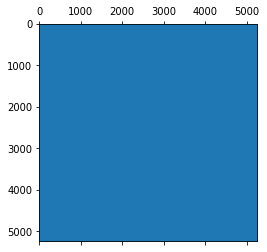

In [38]:
plt.spy(nx.adjacency_matrix(G)) #Visulazing (Just to see visual differences)

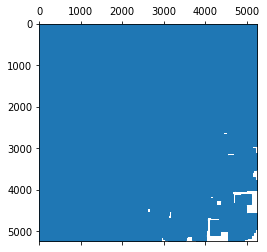

In [39]:
plt.spy(nx.adjacency_matrix(gc))

In [40]:
print('Percentage of the adjacency matrix that differs ', 
      100*(np.sum((nx.adjacency_matrix(G) - nx.adjacency_matrix(gc)) != 0))/N**2)

Percentage of the adjacency matrix that differs  0.210294832001


So, clearly, while being mostly similar they are **NOT EXCATLY** the same. This is expected since, while the second graph has the same degree for each node, this only constrains the sum of the elements of each row od the adjacency matrix. The individual elements of the each row are chosen by the random process and are free to vary as long as the sum remains the same. 

On a higher level, the structure differs because of the property of **preferential attachment** in the network construction process as explained in the next graph.

2.4 Draw both the generated and original networks. Are they similar? If not, why? Try to explain.

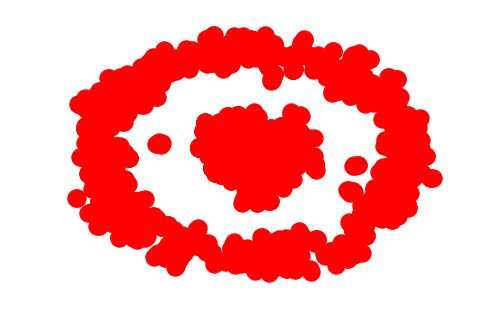

In [41]:
nx.draw(G)

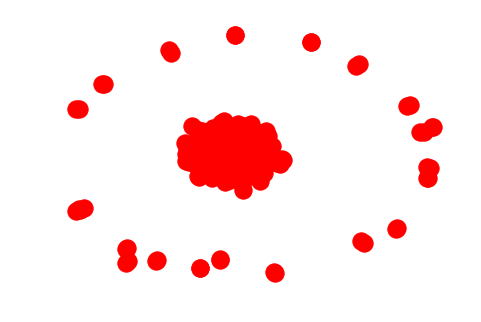

In [42]:
nx.draw(gc)

Clearly, the two graphs are not similar in structure. We can check the size of the giant component first :

In [43]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_gc = max(nx.connected_component_subgraphs(gc), key=len)
print('Number of nodes inside giant component of The Original graph', len(giant_G.nodes()) ,
                                                                          'and outside it is ', N- len(giant_G.nodes() ))
print('Number of nodes inside giant component of The created graph', len(giant_gc.nodes() ),
                                                                         'and outside it is ', N- len(giant_gc.nodes()))


Number of nodes inside giant component of The Original graph 4158 and outside it is  1084
Number of nodes inside giant component of The created graph 5200 and outside it is  42


The size of the giant component is much larger in our created grpah because of the property of **preferential attachment** induced by selecting the node on the basis of the number o free stubs left thus creating bigger connected component. The other smaller reason is tat the econd graph is weighed and thus some of the links are actually more "stronger" than the others but they of course, doon't affect the property except for reducing the number of unique links. 

**However** , this effect is small as can be seen below:

In [44]:
100*(gc.size(weight = 'weight') - gc.size() )/ gc.size()

0.4086721618064695

Thus only `0.45%` of the unique links have weight more than 1 and so this is a small factor.

2.5 Do you expect the properties studied in the first part of the assignment to be close to the original graph? Justify.

**Not really**. We have already looked at the Giant component size which is pretty different. The number of nodes and edges are designmed to be the same/close and so he avergae number of links are also close

In [45]:
print('Average Clustering coefficients')
print('Original Graph',nx.average_clustering(G))
print('Barabasi Albert Model',nx.average_clustering(ba))
print('Erdos Renyi model',nx.average_clustering(er))

Average Clustering coefficients
Original Graph 0.5296358110521372
Barabasi Albert Model 0.0009729988723836835
Erdos Renyi model 0.00010174233753020476


Again, even the order of magnitude of the clustering coefficients are different. So, 
the models in first part are not a good approximation of the original graph